In [1]:
# Import libraries and dependencies
# needed to pip install extra ones to work in Google Colab hence the extra on top
!pip install yfinance
!pip install hvplot
!pip install python-dotenv 
!pip install -q holoviews
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import yfinance as yf
from pathlib import Path

from fbprophet import Prophet
import json
from fbprophet.serialize import model_to_json, model_from_json

import numpy as np
import hvplot.pandas
import holoviews as hv
from holoviews import opts

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
hv.extension('bokeh')
%matplotlib inline

Output hidden; open in https://colab.research.google.com to view.

In [2]:
# Set and use Yahoo Finance fetcher to get as up to date info as possible while formating data
def fetch_yahoo(ticker, years):
    
    range = 365*years
    today = pd.Timestamp.today(tz="America/New_York")

    start = today + pd.Timedelta(days=-1-range)
    start= start.strftime('%Y-%m-%d')
    print(f'Start date = {start}')

    end = today + pd.Timedelta(days=-2)
    end = end.strftime('%Y-%m-%d')
    print(f'End date = {end}')   

    # Get Data
    yfObj = yf.Ticker(ticker)
    stock_df = yfObj.history(start=start, end=end)
    # Drop unused columns
    stock_df.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], inplace=True, axis=1)
    stock_df.reset_index(inplace=True)
    stock_df.rename(columns={'Date':'ds', 'Close':'y'}, inplace=True)
    return stock_df

Start date = 2020-06-11
End date = 2022-06-10


,ds,y
0,2020-06-11,182.989502
1,2020-06-12,184.433640
2,2020-06-15,185.612488
3,2020-06-16,190.160965
4,2020-06-17,190.819138


,ds,y
499,2022-06-03,270.019989
500,2022-06-06,268.750000
501,2022-06-07,272.500000
502,2022-06-08,270.410004
503,2022-06-09,264.790009


(504, 2)


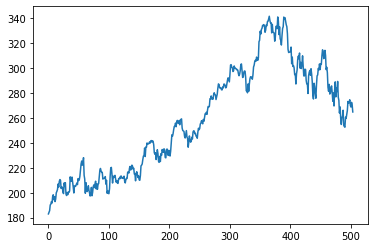

In [3]:
# Create ds, y DataFrame for fbProphet processing 
ticker='MSFT'

# Get current closing prices for MSFT from last two years
msft_df = fetch_yahoo(ticker, 2)

# Display sample data
display(msft_df.head())
display(msft_df.tail())
print(msft_df.shape)


# Plot the DataFrame with hvplot
msft_df['y'].plot()

In [4]:
# Call the Prophet function, store as an object
model_msft = Prophet()
model_msft

In [5]:
# Fit the model
model_msft.fit(msft_df)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [6]:
# Forecast two week of future trends data for MSFT 
# Tweak periods and freq to easily adjust desired sliders
future_msft = model_msft.make_future_dataframe(periods=360, freq="H")

# Display the last five rows of the DataFrame
future_msft

,ds
0,2020-06-11 00:00:00
1,2020-06-12 00:00:00
2,2020-06-15 00:00:00
3,2020-06-16 00:00:00
4,2020-06-17 00:00:00
...,...
859,2022-06-23 20:00:00
860,2022-06-23 21:00:00
861,2022-06-23 22:00:00
862,2022-06-23 23:00:00


In [7]:
# Make predictions for MSFT 
forecast_msft = model_msft.predict(future_msft)

# Preview forecast df
forecast_msft.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
859,2022-06-23 20:00:00,254.928872,245.862871,270.031279,254.679018,255.096951,2.859679,2.859679,2.859679,2.859679,2.859679,2.859679,0.0,0.0,0.0,257.788550
860,2022-06-23 21:00:00,254.913887,246.841908,268.840370,254.662057,255.082749,2.785004,2.785004,2.785004,2.785004,2.785004,2.785004,0.0,0.0,0.0,257.698890
861,2022-06-23 22:00:00,254.898901,245.907410,269.311109,254.643702,255.068462,2.689482,2.689482,2.689482,2.689482,2.689482,2.689482,0.0,0.0,0.0,257.588384
862,2022-06-23 23:00:00,254.883916,245.705329,269.183883,254.626893,255.054075,2.571939,2.571939,2.571939,2.571939,2.571939,2.571939,0.0,0.0,0.0,257.455855
863,2022-06-24 00:00:00,254.868931,245.495973,269.371921,254.609361,255.039804,2.431373,2.431373,2.431373,2.431373,2.431373,2.431373,0.0,0.0,0.0,257.300304


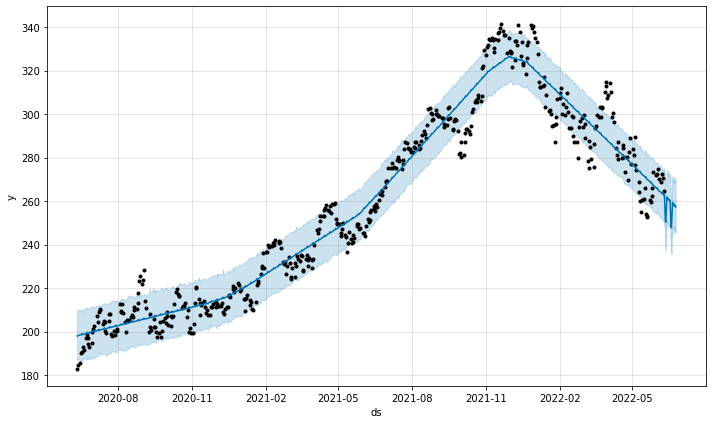

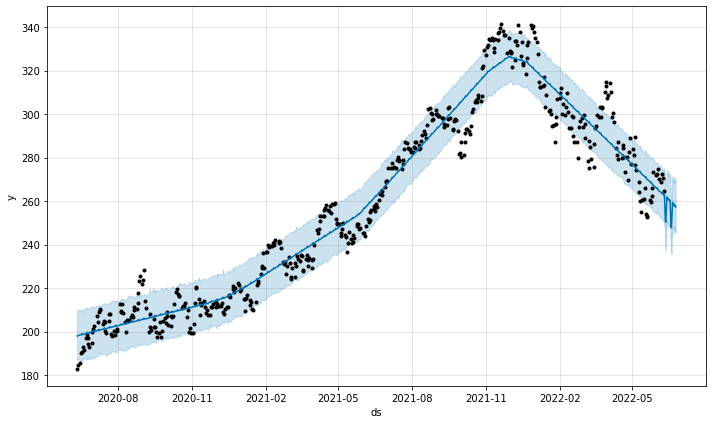

In [8]:
# Plot the forecast
model_msft.plot(forecast_msft)

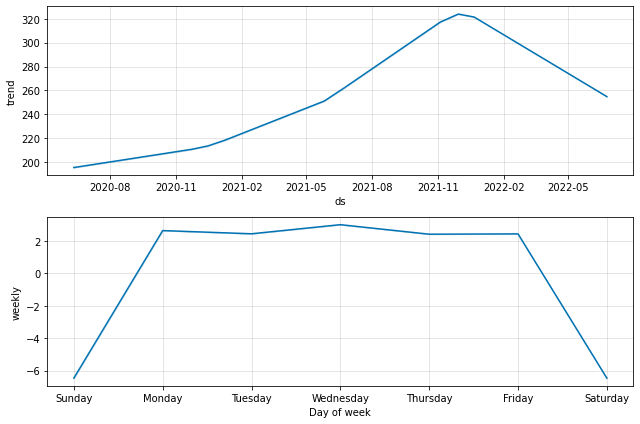

In [9]:
# Plot the different patterns
fig_msft = model_msft.plot_components(forecast_msft)

In [10]:
# Analyze the forecast results specifially for the two week period
forecast_msft = forecast_msft.set_index('ds')
forecast_msft.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2020-06-11,195.546421,186.807616,209.435349,195.546421,195.546421,2.412917,2.412917,2.412917,2.412917,2.412917,2.412917,0.0,0.0,0.0,197.959339
2020-06-12,195.638741,187.471842,210.060928,195.638741,195.638741,2.431373,2.431373,2.431373,2.431373,2.431373,2.431373,0.0,0.0,0.0,198.070114
2020-06-15,195.915701,186.551157,209.925673,195.915701,195.915701,2.635201,2.635201,2.635201,2.635201,2.635201,2.635201,0.0,0.0,0.0,198.550902
2020-06-16,196.008021,186.618836,209.778424,196.008021,196.008021,2.438507,2.438507,2.438507,2.438507,2.438507,2.438507,0.0,0.0,0.0,198.446529
2020-06-17,196.100341,187.041645,210.251925,196.100341,196.100341,2.999516,2.999516,2.999516,2.999516,2.999516,2.999516,0.0,0.0,0.0,199.099857


yhat          257.741285
yhat_lower    246.163962
yhat_upper    269.299891
dtype: float64

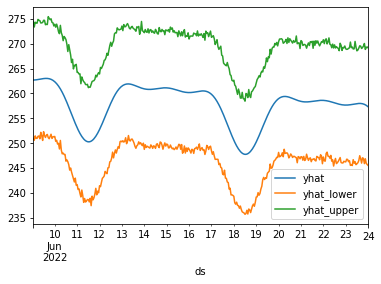

In [12]:
# Plot the results for the next two weeks & get the mean
forecast_two_week_plot = forecast_msft[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-360:,:].plot()
forecast_two_week_plot
forecast_msft[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-360:,:].mean()

In [13]:
# Rename forecast columns to something more readable & splice time period to analyze
two_week_forecast = forecast_msft.iloc[-360:,:][['yhat_upper', 'yhat_lower', 'yhat']]

two_week_forecast = two_week_forecast.rename(
    columns={
        'yhat_upper': 'Best Case',
        'yhat_lower':'Worst Case', 
        'yhat':'Most Likely Case'
    }
)
two_week_forecast

,Best Case,Worst Case,Most Likely Case
ds,,,
2022-06-09 01:00:00,274.467199,250.952060,262.678851
2022-06-09 02:00:00,273.346993,250.564634,262.687824
2022-06-09 03:00:00,274.315536,251.443393,262.703019
2022-06-09 04:00:00,274.148561,250.973764,262.723849
2022-06-09 05:00:00,274.115550,250.950637,262.749567
...,...,...,...
2022-06-23 20:00:00,270.031279,245.862871,257.788550
2022-06-23 21:00:00,268.840370,246.841908,257.698890
2022-06-23 22:00:00,269.311109,245.907410,257.588384


In [14]:
# Find the mean data
two_week_forecast.mean()

Best Case           269.299891
Worst Case          246.163962
Most Likely Case    257.741285
dtype: float64

In [ ]:
# Save prophet data to csv (this specifically for google colab)
two_week_forecast.to_csv('/content/two_week_prophet.csv')

In [20]:
# Create new hlc dataframe from data for fbprophet to backtest against

backtest_msft_df = pd.read_csv(Path(
    "Resources/msft_hlc.csv"), 
    parse_dates = True,
    index_col= "Date",
    infer_datetime_format = True
)
backtest_msft_df.tail()

# Use this code when in colab
# backtest_msft_df = pd.read_csv(Path(
#     "/content/msft_hlc.csv"), 
#     parse_dates = True,
#     index_col= "Date", 
#     infer_datetime_format = True
# )
# backtest_msft_df

,high,low,close
Date,,,
1987-01-02,0.106396,0.103668,0.104214
1987-01-05,0.111306,0.103668,0.110215
1987-01-06,0.112398,0.109670,0.111852
1987-01-07,0.117854,0.111852,0.117854
1987-01-08,0.122765,0.118400,0.121673
...,...,...,...
2022-04-25,280.456766,270.140797,280.067688
2022-04-26,277.713172,269.372612,269.592102
2022-04-27,290.293881,278.511326,282.561890


In [23]:
# Splice date range to compare on hlc dataframe
msft_actual_april_2022 = backtest_msft_df.loc['2022-04-01':'2022-04-30']
msft_actual_april_2022


,high,low,close
Date,,,
2022-04-01,309.409361,304.830030,308.701019
2022-04-04,314.377757,308.990311,314.238098
2022-04-05,314.138342,309.149960,310.157623
2022-04-06,306.286619,296.020521,298.804047
2022-04-07,302.944409,295.661384,300.669708
2022-04-08,300.420288,295.591539,296.279938
2022-04-11,291.930065,284.337762,284.597168
2022-04-12,290.064394,279.838212,281.404572
2022-04-13,287.909421,280.646338,286.951660


In [26]:
# Get mean data for comparison purposes
msft_actual_april_2022.mean()

high     293.229537
low      285.037119
close    288.139394
dtype: float64

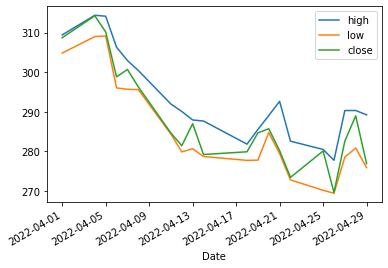

In [29]:
# Plot the data (hvplots would be better for better comparison)
actual_april2022_plot = msft_actual_april_2022.plot()
actual_april2022_plot

In [31]:
# Get same date range from prophet forecast dataframe
forecast_april_2022 = forecast_msft.loc['2022-04-01':'2022-04-30'][['yhat_upper', 'yhat_lower', 'yhat']]
forecast_april_2022

,yhat_upper,yhat_lower,yhat
ds,,,
2022-04-01,299.179896,275.281410,287.510482
2022-04-04,297.690775,275.682641,286.635375
2022-04-05,297.746764,273.978706,286.079037
2022-04-06,298.115446,274.241896,286.280400
2022-04-07,295.997804,273.554461,285.334157
2022-04-08,295.219484,273.207535,284.992967
2022-04-11,295.061755,273.006907,284.117861
2022-04-12,294.562417,271.975656,283.561522
2022-04-13,295.539546,271.579048,283.762885


In [34]:
# Gather mean data for comparison
forecast_april_2022.mean()

yhat_upper    293.684767
yhat_lower    270.808079
yhat          282.339866
dtype: float64

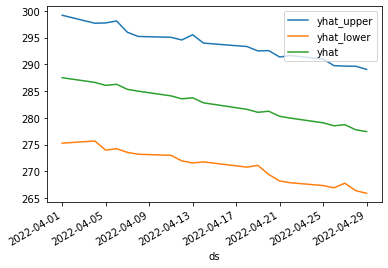

In [35]:
# Plot data (again hvplots would be better in order to overlay directly)
forecast_april2022_plot = forecast_april_2022.plot()
forecast_april2022_plot

In [36]:
# Overlay forecast plot and actual price plot using hvplot (does not work with Mac + Colab)
# april_comparative_plot = forecast_april2022_plot * actual_april2022_plot
# april_comparative_plot

In [ ]:
# Forecast 1 month of future trends data for MSFT using different parameters
month_future_msft = model_msft.make_future_dataframe(periods=30, freq="D")

# Display the DataFrame
month_future_msft

,ds
0,2020-06-10
1,2020-06-11
2,2020-06-12
3,2020-06-15
4,2020-06-16
...,...
529,2022-07-04
530,2022-07-05
531,2022-07-06
532,2022-07-07


In [ ]:
# Make 1 month prediction
month_msft_forecast = model_msft.predict(month_future_msft)

# Preview forecast df
month_msft_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-10,196.736777,186.139172,209.262849,196.736777,196.736777,1.160574,1.160574,1.160574,1.160574,1.160574,1.160574,0.0,0.0,0.0,197.897351
1,2020-06-11,196.835010,186.221735,208.790327,196.835010,196.835010,0.611871,0.611871,0.611871,0.611871,0.611871,0.611871,0.0,0.0,0.0,197.446881
2,2020-06-12,196.933244,186.298728,209.687208,196.933244,196.933244,0.636966,0.636966,0.636966,0.636966,0.636966,0.636966,0.0,0.0,0.0,197.570209
3,2020-06-15,197.227945,186.977579,209.343468,197.227945,197.227945,0.843659,0.843659,0.843659,0.843659,0.843659,0.843659,0.0,0.0,0.0,198.071604
4,2020-06-16,197.326178,185.203558,208.515424,197.326178,197.326178,0.645653,0.645653,0.645653,0.645653,0.645653,0.645653,0.0,0.0,0.0,197.971831


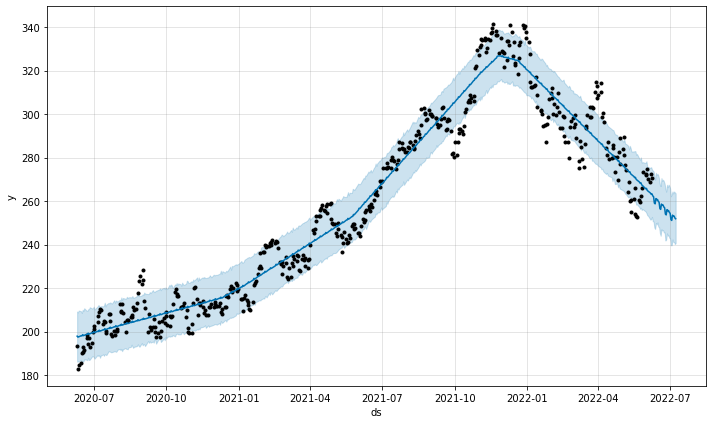

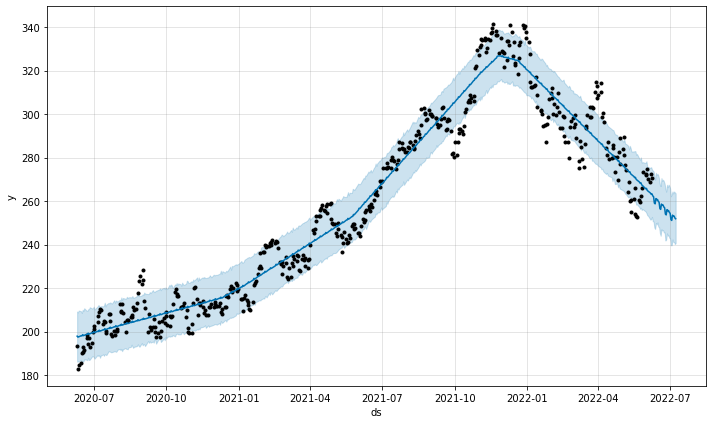

In [ ]:
# Plot the month prediciton
model_msft.plot(month_msft_forecast)

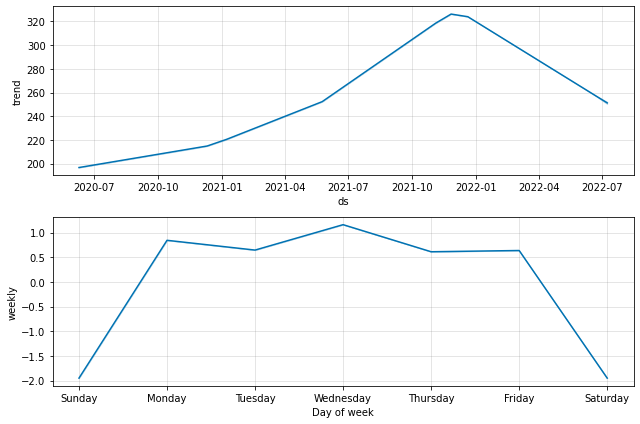

In [ ]:
# Plot the main components of the forecast table
fig_2_msft = model_msft.plot_components(month_msft_forecast)

In [ ]:
# Reset index to ds for further processing
month_msft_forecast = month_msft_forecast.set_index('ds')
month_msft_forecast.tail(30)

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2022-06-09,261.778563,250.667229,274.045364,261.778563,261.778563,0.611871,0.611871,0.611871,0.611871,0.611871,0.611871,0.0,0.0,0.0,262.390434
2022-06-10,261.415175,250.630918,273.694428,261.415175,261.415175,0.636966,0.636966,0.636966,0.636966,0.636966,0.636966,0.0,0.0,0.0,262.052140
2022-06-11,261.051786,247.811082,271.999078,261.051786,261.051786,-1.949361,-1.949361,-1.949361,-1.949361,-1.949361,-1.949361,0.0,0.0,0.0,259.102425
2022-06-12,260.688398,247.145408,269.818604,260.688398,260.688398,-1.949362,-1.949362,-1.949362,-1.949362,-1.949362,-1.949362,0.0,0.0,0.0,258.739036
2022-06-13,260.325010,249.961326,273.015460,260.325010,260.325010,0.843659,0.843659,0.843659,0.843659,0.843659,0.843659,0.0,0.0,0.0,261.168669
2022-06-14,259.961621,249.238324,272.033970,259.959738,259.961621,0.645653,0.645653,0.645653,0.645653,0.645653,0.645653,0.0,0.0,0.0,260.607274
2022-06-15,259.598233,250.196421,272.537266,259.582207,259.598233,1.160574,1.160574,1.160574,1.160574,1.160574,1.160574,0.0,0.0,0.0,260.758807
2022-06-16,259.234844,248.276177,271.874608,259.202318,259.240481,0.611871,0.611871,0.611871,0.611871,0.611871,0.611871,0.0,0.0,0.0,259.846715
2022-06-17,258.871456,248.009157,270.226597,258.819715,258.886608,0.636966,0.636966,0.636966,0.636966,0.636966,0.636966,0.0,0.0,0.0,259.508422


In [ ]:
month_prediction = month_msft_forecast.iloc[-30:,:][['yhat_upper', 'yhat_lower', 'yhat']]

In [ ]:
# Rename columns to be easier to read
month_prediction = month_prediction.rename(
    columns={
        'yhat_upper': 'Best Case',
        'yhat_lower':'Worst Case', 
        'yhat':'Most Likely Case'
    }
)

# Review the last five rows of the DataFrame
month_prediction.head()
month_prediction.tail()

,Best Case,Worst Case,Most Likely Case
ds,,,
2022-07-04,264.477557,242.380305,253.537512
2022-07-05,263.449823,241.182433,252.976118
2022-07-06,264.435202,241.237202,253.127651
2022-07-07,263.995076,240.184904,252.215559
2022-07-08,263.606577,240.722938,251.877265


In [ ]:
# Seperate the predicted month data specifically
forecast_month = month_msft_forecast.loc['2022-04-30':'2022-05-29'][['yhat_upper', 'yhat_lower', 'yhat']]

In [ ]:
# Rename columns to be easier to read
forecast_month = forecast_month.rename(
    columns={
        'yhat_upper': 'Best Case',
        'yhat_lower':'Worst Case', 
        'yhat':'Most Likely Case'
    }
)

# Review the last five rows of the DataFrame
forecast_month

,Best Case,Worst Case,Most Likely Case
ds,,,
2022-05-02,287.634642,264.967111,276.430981
2022-05-03,287.265628,264.727167,275.869587
2022-05-04,288.389334,264.243630,276.021120
2022-05-05,286.386079,263.398955,275.109028
2022-05-06,286.360676,263.145307,274.770734
2022-05-09,285.428619,261.671869,273.887262
2022-05-10,283.702856,261.741213,273.325868
2022-05-11,285.438069,262.358842,273.477401
2022-05-12,284.408752,261.025819,272.565309


In [ ]:
forecast_month.mean()

Best Case           283.247430
Worst Case          260.414963
Most Likely Case    271.824712
dtype: float64

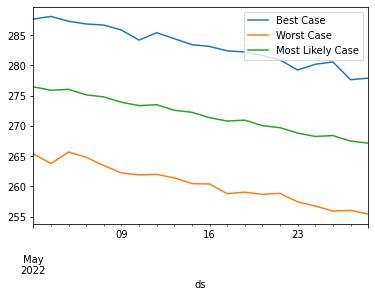

In [ ]:
forecast_month.plot()

In [ ]:
# Save data to csv to use in algorithims
forecast_month.to_csv('/content/month_prophet.csv')